# Triangulation

# 3D Cartesian Triangulation

### Overview
Triangulation happens in two steps:
1. First a linear system is solved for initial guess. This linear system doesnt take into account any noise. Hence its the initial guess.
2. Using initial guess, a non linear system is optimized to give final estimate which can incorporate noise.

### Assumption
1. All the poses that the feature is seen from to be of known quantity. This means we assume that all the clones where the feature was seen from, have known poses (these are not known exactly but estimated using the EKF).
2. Extrinsics, intrinsics and offsets are assumed to be known and exact.

### Input
Givens:
1. u,v of the feature $f$ in $i=1,...,m$
2. Pose and hence camera pose (assuming extrinsics and intrinsics are known and given) in times $i=1,...,m$

### Output
${}^{A}p_{f} = [x,y,z]$ of feature $f$ in a known frame $A$. $A$ is an arbitrary pick from $i=1,...,m$

### Step 1: Linear system
We wish to create a solvable linear system that can give us an initial guess for the **3D cartesian position** of our feature. This feature will be triangulated in some anchor camera frame $\{A\}$ which we can arbitrary pick. If the feature $\mathbf{p}_f$, is observed by pose $1...m$, given the anchor pose $A$, we can have the following transformation from any camera pose $C_i, i = 1...m$:

$$^{C_i} \mathbf{p}_f = {}^{C_i}_{A} \mathbf{R} ({}^A \mathbf{p}_f - {}^A \mathbf{p}_{C_i})$$
$${}^A \mathbf{p}_f = {}^{C_i}_A \mathbf{R}^{\mathsf{T}} {}^{C_i} \mathbf{p}_f + {}^A \mathbf{p}_{C_i}$$

In the absents of noise, the measurement in the current frame is the bearing $^{C_i}\mathbf{b}$ and its depth $^{C_i} z$. Thus we have the following mapping to a feature seen from the current frame:

$${}^{C_i} \mathbf{p}_f = {}^{C_i} z_f {}^{C_i} \mathbf{b}_f = {}^{C_i} z_f \begin{bmatrix} u_n \\ v_n \\ 1 \end{bmatrix}$$

We note that $u_n$ and $v_n$ represent the undistorted normalized image coordinates. This bearing can be warped into the the anchor frame by substituting into the above equation:

$${}^{A} \mathbf{p}_f = {}^{C_i}_{A} \mathbf{R}^{\mathsf{T}} {}^{C_i} z_f {}^{C_i} \mathbf{b}_f + {}^{A} \mathbf{p}_{C_i}$$
$$ = {}^{C_i} z_f {}^{A} \mathbf{b}_{C_i \to f} + {}^{A} \mathbf{p}_{C_i}$$

To remove the need to estimate the extra degree of freedom of depth $^{C_i} z_f$, we define the following vectors which are orthoganal to the bearing ${}^A \mathbf{b}_{C_i \to f}$:

$${}^A \mathbf{N}_i = [ {}^A \mathbf{b}_{C_i \to f} \times ] = \begin{bmatrix} 0 & -{}^A \mathbf{b}_{C_i \to f}(3) & {}^A \mathbf{b}_{C_i \to f}(2) \\ {}^A \mathbf{b}_{C_i \to f}(3) & 0 & -{}^A \mathbf{b}_{C_i \to f}(1) \\ -{}^A \mathbf{b}_{C_i \to f}(2) & {}^A \mathbf{b}_{C_i \to f}(1) & 0 \end{bmatrix}$$

All three rows are perpendicular to the vector ${}^A \mathbf{b}_{C_i \to f}$ and thus ${}^A \mathbf{N}_i {}^A \mathbf{b}_{C_i \to f} = \mathbf{0}_{3}$. We can then multiple the transform equation/constraint to form two equation which only relates to the unknown 3 d.o.f $\mathbf{p}_f$:

$${}^A \mathbf{N}_i {}^A \mathbf{p}_f = {}^A \mathbf{N}_i {}^{C_i} z_f {}^{A}_{C_i} \mathbf{R} {}^{C_i} \mathbf{b}_f + {}^A \mathbf{N}_i {}^A \mathbf{p}_{C_i}$$
$$ = {}^{A} \mathbf{N}_i {}^{A} \mathbf{p}_{C_i}$$

By stacking all the measurements, we can have:

$$\underbrace{\begin{bmatrix} {}^A \mathbf{N}_1 \\ \vdots \\ {}^A \mathbf{N}_m \end{bmatrix}}_{\mathbf{A}} {}^A \mathbf{p}_f = \underbrace{\begin{bmatrix} {}^A \mathbf{N}_1 {}^A \mathbf{p}_{C_1} \\ \vdots \\ {}^A \mathbf{N}_m {}^A \mathbf{p}_{C_m} \end{bmatrix}}_{\mathbf{b}}$$

Since each pixel measurement provides two constraints, as long as $m > 1$, we will have enough constraints to triangulate the feature. In practice, the more views of the feature the better the triangulation and thus normally want to have a feature seen from at least five views.

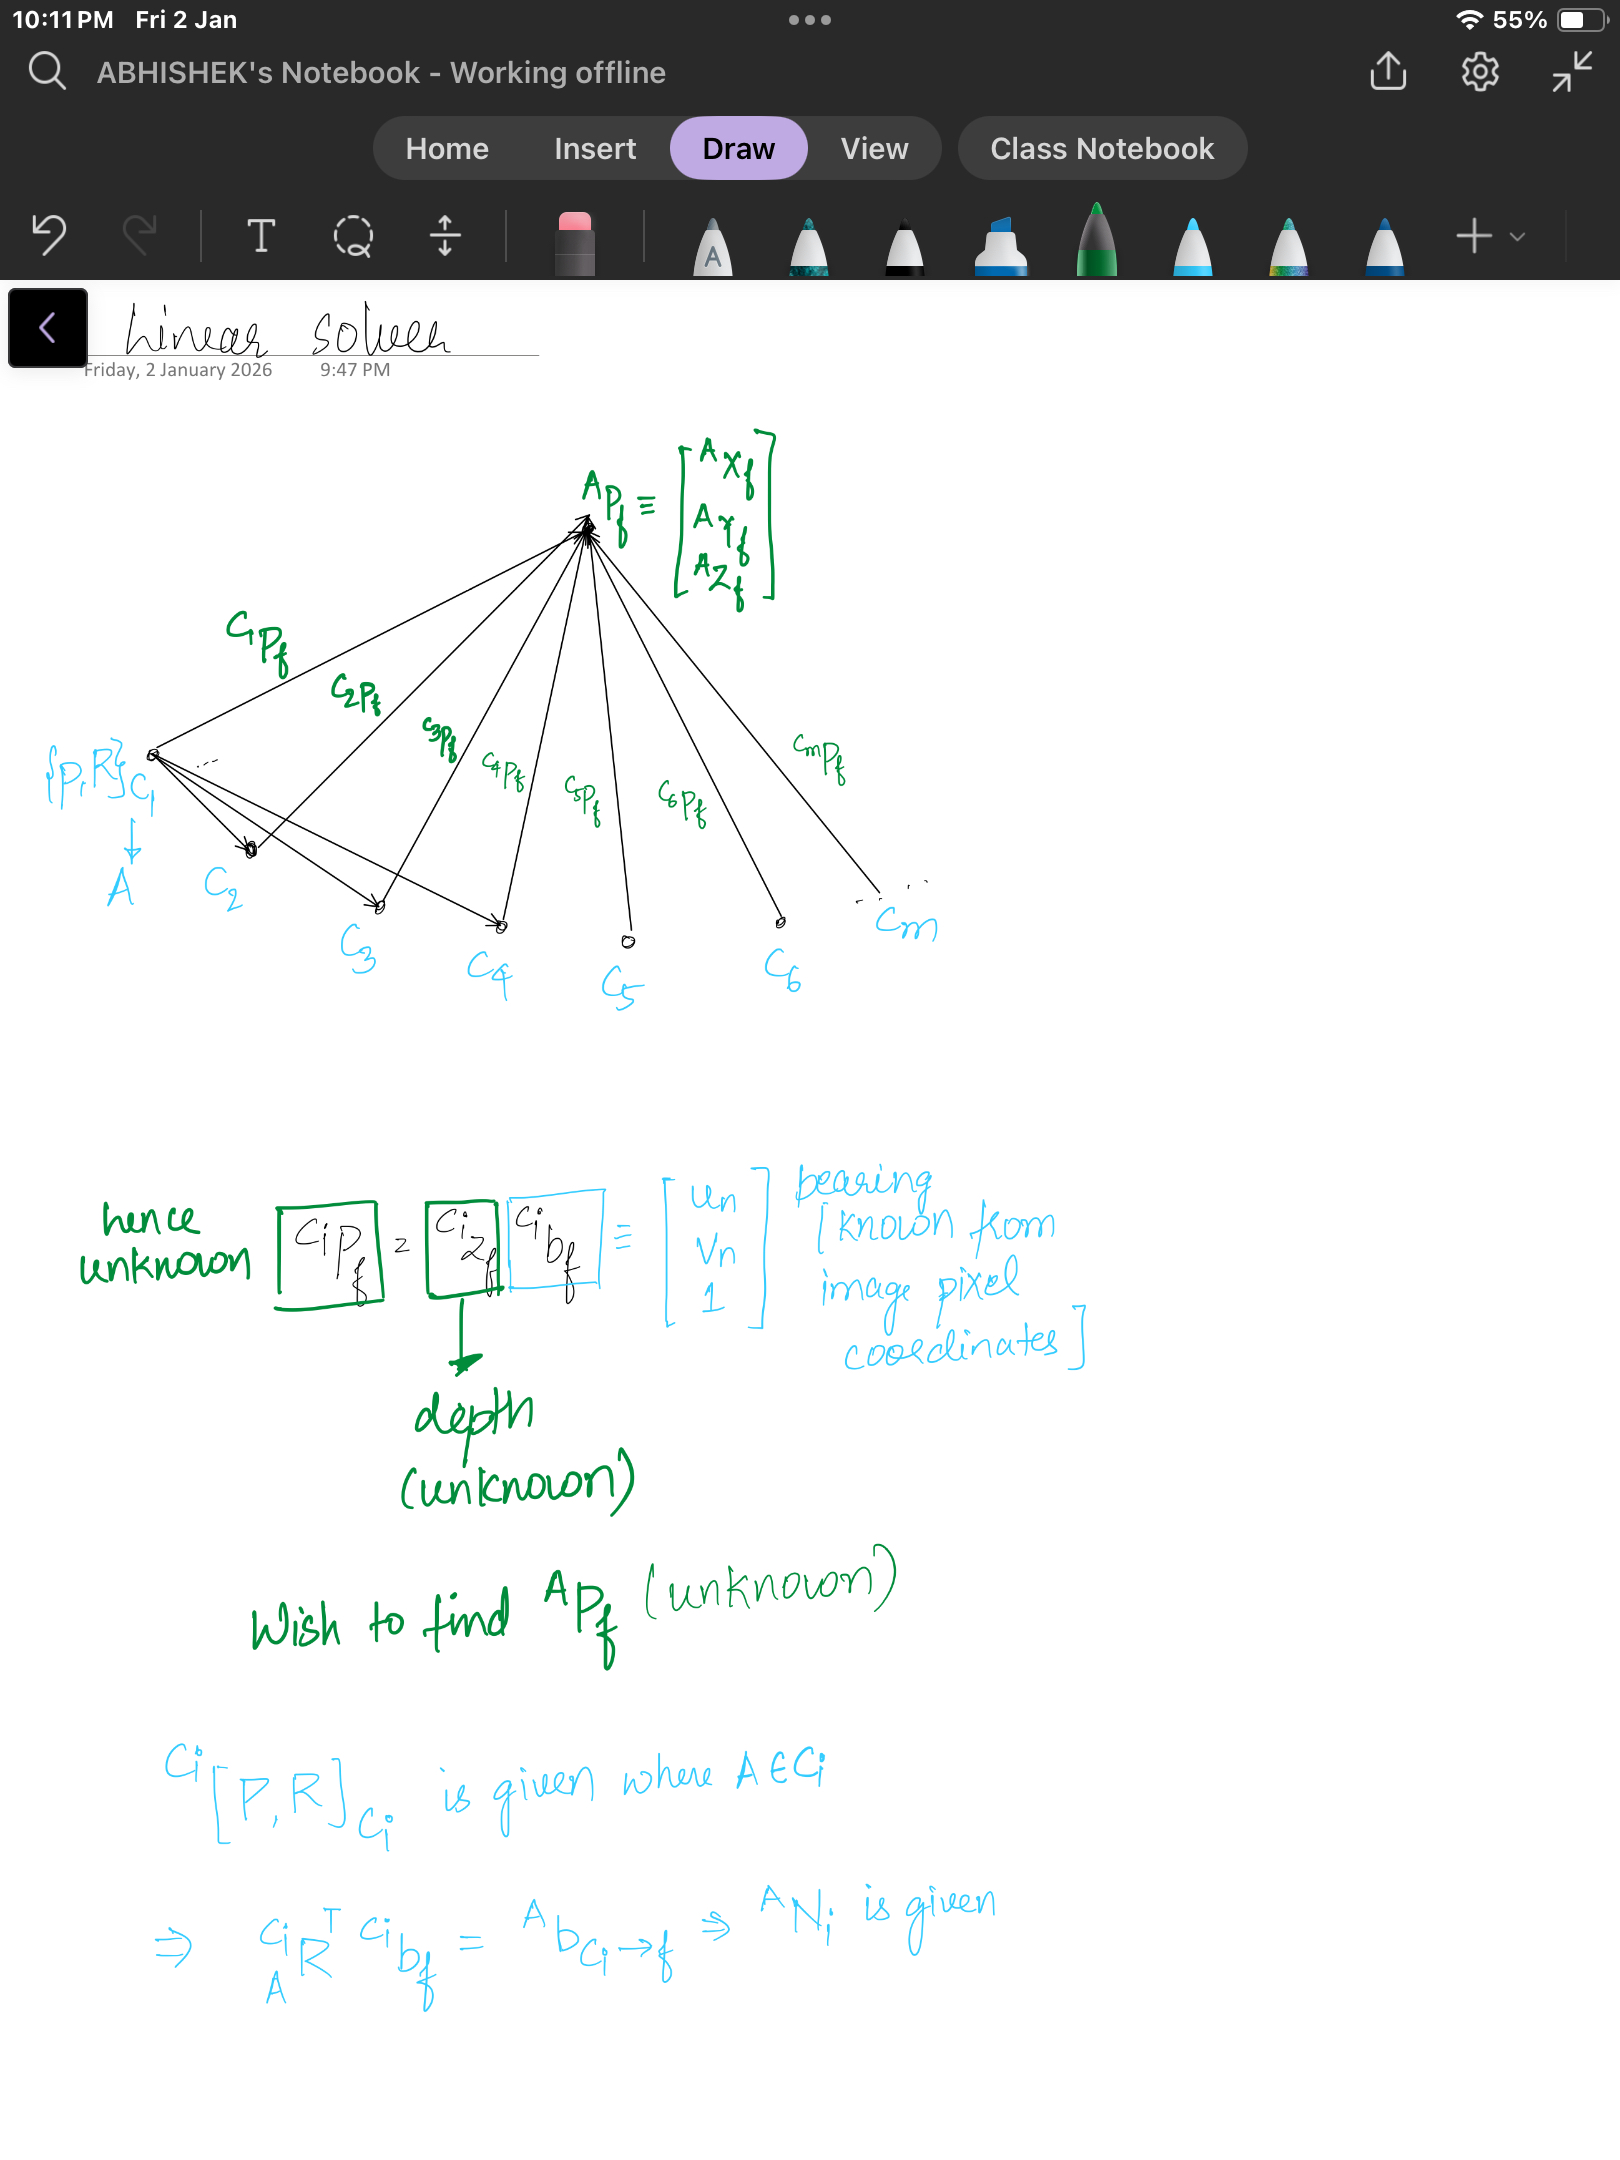

### Step 2: 3D Inverse Non-linear Optimization

After we get the triangulated feature **3D position**, a **nonlinear least-squares** will be performed to refine this estimate. In order to achieve good numerical stability, we use the **inverse depth representation** for point feature which helps with **convergence**. We find that in most cases this problem converges within **2-3 iterations** in indoor environments. The feature transformation can be written as:


$$^{C_i}\mathbf{p}_f = {}^{C_i}_{A}\mathbf{R} ({}^A\mathbf{p}_f - {}^A\mathbf{p}_{C_i})$$

$$= {}^{A}z_f {}^{C_i}_{A}\mathbf{R} \left( \begin{bmatrix} {}^A x_f / {}^A z_f \\ {}^A y_f / {}^A z_f \\ 1 \end{bmatrix} - \frac{1}{{}^A z_f}{}^A\mathbf{p}_{C_i} \right)$$

$$\implies \frac{1}{{}^A z_f} {}^{C_i}\mathbf{p}_f = {}^{C_i}_{A}\mathbf{R} \left( \begin{bmatrix} {}^A x_f / {}^A z_f \\ {}^A y_f / {}^A z_f \\ 1 \end{bmatrix} - \frac{1}{{}^A z_f}{}^A\mathbf{p}_{C_i} \right)$$


We define $u_A = {}^A x_f / {}^A z_f$, $v_A = {}^A y_f / {}^A z_f$, and $\rho_A = 1/{}^A z_f$ to get the following measurement equation: ($u_A, v_A, \rho_A, {}^{C_i}_{A}\mathbf{R}, {}^A\mathbf{p}_{C_i}$ are knowns)

$$h(u_A, v_A, \rho_A) = {}^{C_i}_{A}\mathbf{R} \left( \begin{bmatrix} u_A \\ v_A \\ 1 \end{bmatrix} - \rho_A {}^A\mathbf{p}_{C_i} \right)$$


The feature measurement seen from the $\{C_i\}$ camera frame can be reformulated as:

$$\mathbf{z} = \begin{bmatrix} u_i \\ v_i \end{bmatrix} = \begin{bmatrix} ({}^{C_i} x_f/{}^{A} z_f) / ({}^{C_i} z_f/{}^{A} z_f) \\ ({}^{C_i} y_f/{}^{A} z_f) / ({}^{C_i} z_f/{}^{A} z_f) \end{bmatrix} = \begin{bmatrix} h(u_A, v_A, \rho_A)(1)/h(u_A, v_A, \rho_A)(3) \\ h(u_A, v_A, \rho_A)(2)/h(u_A, v_A, \rho_A)(3) \end{bmatrix} = \mathbf{h}(u_A, v_A, \rho_A)$$


Therefore, we can have the least-squares formulated and Jacobians:

$$\argmin_{u_A, v_A, \rho_A} ||\mathbf{z} - \mathbf{h}(u_A, v_A, \rho_A)||^2$$

z is the uv from the measurements from image tracking, $\mathbf{h}(u_A, v_A, \rho_A)$ is known formula and $u_A, v_A, \rho_A$ are being initialized with the initial guess and we optimize for them.

$$\frac{\partial \mathbf{h}(u_A, v_A, \rho_A)}{\partial h(u_A, v_A, \rho_A)} = \begin{bmatrix} 1/h(...)(3) & 0 & -h(...)(1)/h(...)(3)^2 \\ 0 & 1/h(...)(3) & -h(...)(2)/h(...)(3)^2 \end{bmatrix}$$

$$\frac{\partial h(u_A, v_A, \rho_A)}{\partial [u_A, v_A, \rho_A]} = {}^{C_i}_{A}\mathbf{R} \begin{bmatrix} 1 & 0 & \\ 0 & 1 & -^{A}\mathbf{p}_{C_i} \\ 0 & 0 & \end{bmatrix}$$

The least-squares problem can be solved with Gaussian-Newton or Levenberg-Marquart algorithm..
